<a href="https://colab.research.google.com/github/ArpitRawat07/GenerativeAdversarialNetwork/blob/main/GAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network(GAN) for fashion generation using Fashion-mnist Dataset

## Importing Data and Dependencies

In [1]:
# Importing dependencies
import numpy as np
from numpy import zeros, ones, asarray
from numpy.random import randint, randn

import cv2

import matplotlib.pyplot as plt
import os
from os import listdir, makedirs
from PIL import Image
import warnings
from tqdm.notebook import tqdm
import random
from glob import glob

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import Callback
from keras.utils import plot_model

import shutil
import zipfile

In [2]:
# Turning on mixed precision for gpu
tf.keras.mixed_precision.set_global_policy('mixed_float16')
tf.keras.mixed_precision.global_policy()

<Policy "mixed_float16">

In [63]:
(train_data, test_data), ds_info = tfds.load(name='mnist',
                                             split=['train', 'test'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [64]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [65]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [66]:
class_names = ds_info.features['label'].names
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [67]:
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [68]:
for img, label in train_one_sample:
  print(f"""
  Image shape: {img.shape}
  Image_datatype: {img.dtype}
  Target class from fashion_mnist: {label}
  class_name: {class_names[label.numpy()]}
        """)


  Image shape: (28, 28, 1)
  Image_datatype: <dtype: 'uint8'>
  Target class from fashion_mnist: 4
  class_name: 4
        


In [69]:
img

<tf.Tensor: shape=(28, 28, 1), dtype=uint8, numpy=
array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],


In [70]:
# Finding the minimum and the maximum values in the image
tf.reduce_min(img), tf.reduce_max(img)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 27.5, 27.5, -0.5)

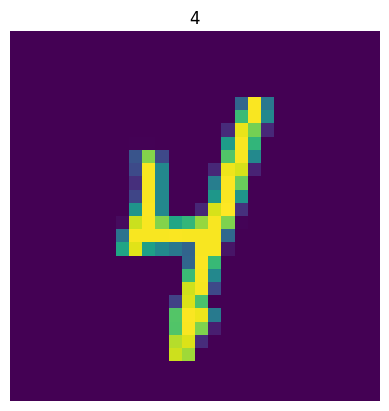

In [71]:
# Plotting the image
plt.imshow(img)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [72]:
def preprocess_img(image, label, img_shape=28):
  """
  Takes images and labels
  Converts the image from 'uint8' to 'float32' and rescaling the image values to 0-1.
  Returns just the images
  """
  image = tf.cast(image, tf.float32)
  return image/255.

In [73]:
# Preprocessing the train dataset
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffling the train dataset, making batches of 128 and prefetch(loading the dataset faster)
train_data = train_data.shuffle(buffer_size=6000).batch(batch_size=128).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing the test dataset
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffling the test dataset, making batches of 128 and prefetch(loading the dataset faster)
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=128).prefetch(buffer_size=tf.data.AUTOTUNE)


### Till here we have preprocessed our images and removed the labels from the dataset. Now, let's see some random images.

In [74]:
train_data

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

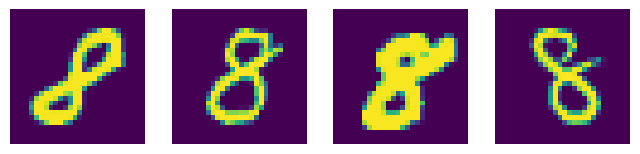

In [75]:
# plotting some random images
random_imgs = train_data.take(1)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 8))
for batch in random_imgs:
  for j, img in enumerate(batch[:4]):
    ax[j].imshow(img)
    ax[j].axis(False)

## Building Generator

In [76]:
# Generator
def generator():

  # Taking input noise
  input_noise = Input(shape = (128, ), name = "Input_Layer")

  # Reshaping to 3D tensor
  x = Dense(7*7*128)(input_noise)
  x = LeakyReLU(0.2)(x)
  x = Reshape((7, 7, 128))(x)

  # Upsampling block 1
  x = UpSampling2D()(x)
  x = Conv2D(128, 5, padding = 'same')(x)
  x = LeakyReLU(0.2)(x)

  # Upsampling block 2
  x = UpSampling2D()(x)
  x = Conv2D(128, 5, padding = 'same')(x)
  x = LeakyReLU(0.2)(x)

  # Convolutional block 1
  x = Conv2D(128, 4, padding = 'same')(x)
  x = LeakyReLU(0.2)(x)

  # Convolutional block 2
  x = Conv2D(128, 4, padding = 'same')(x)
  x = LeakyReLU(0.2)(x)

  # Output Layer
  x = Conv2D(1, 4, padding = 'same')(x)
  generated_img = Activation('sigmoid', dtype = tf.float32, name = 'generator_sigmoid_float32')(x)

  # Model
  model = Model(inputs = input_noise, outputs = generated_img, name = "Generator_Model")

  return model

In [77]:
# Create generator object
generator = generator()
generator.summary()

Model: "Generator_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 128)]             0         
                                                                 
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                   

1/1 [==============================] - 0s 139ms/step


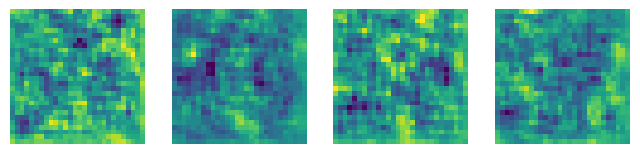

In [78]:
# generating random noise [4 images of 128 input noise vector and 1 color channel]
imgs = generator.predict(randn(4, 128, 1))
fig, ax = plt.subplots(1, 4, figsize=(8, 8))
for j, img in enumerate(imgs):
  ax[j].imshow(img)
  ax[j].axis(False)

### Great!!! Image successfully generated.
 We are able to generate random fashion images. It's just that they are all full of noise. We can improve the performance of our generator using a discriminator. Let's build one.

## Building Discriminator

In [79]:
def discriminator():

  # Taking an image as input
  input_img = Input(shape = (28, 28, 1), name = "Input_Layer")

  # Convolutional block 1
  x = Conv2D(32, 5)(input_img)
  x = LeakyReLU(0.2)(x)
  x = Dropout(0.4)(x)

  # Convolutional block 2
  x = Conv2D(64, 5)(x)
  x = LeakyReLU(0.2)(x)
  x = Dropout(0.4)(x)

  # Convolutional block 3
  x = Conv2D(128, 5)(x)
  x = LeakyReLU(0.2)(x)
  x = Dropout(0.4)(x)

  # Convolutional block 4
  x = Conv2D(256, 5)(x)
  x = LeakyReLU(0.2)(x)
  x = Dropout(0.4)(x)

  # Flatten Layer
  x = Flatten()(x)
  x = Dropout(0.4)(x)

  # Output Layer
  x = Dense(1)(x)
  output = Activation("sigmoid", dtype = tf.float32, name = "discriminator_sigmoid_float32")(x)

  # Model
  model = Model(inputs = input_img, outputs = output, name = "Discriminator_Model")

  return model

In [80]:
# Creating discriminator object
discriminator = discriminator()
discriminator.summary()

Model: "Discriminator_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)

In [81]:
discriminator.predict(tf.expand_dims(img, axis=0))

1/1 [==============================] - 0s 101ms/step


array([[0.5053442]], dtype=float32)

### So, the discriminator predicted an image generated by the generator.
With a prediction of approximately 0.516, the model is assigning a probability of around 51.6% to the input image being a fake sample.

This indicates that the model is not so sure of the image of being a real/fake sample.

This is due as it's incomplete training.
So, Let's train the models.

## Training GAN

### Setting up losses and optimizers.

In [82]:
# Optimizers and loss functions
generator_optimizer = Adam(learning_rate = 0.0001)
discriminator_optimizer = Adam(learning_rate = 0.0001)

generator_loss = BinaryCrossentropy()
discriminator_loss = BinaryCrossentropy()

In [83]:
# Inheriting additional functionalities from Model class in keras
class GAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    # Passing arguments to the base class
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss, *args, **kwargs):
    # Compiling the model with the base class
    super().compile(*args, **kwargs)

    # Create attributes for losses and optimizers
    self.generator_optimizer = generator_optimizer
    self.generator_loss = generator_loss
    self.discriminator_optimizer = discriminator_optimizer
    self.discriminator_loss = discriminator_loss

  def call(self, inputs, training = False, *args, **kwargs):
    # Call method for generating images during inference
    generated_imgs = self.generator(tf.random.normal((1,128)), training)
    return generated_imgs

  def train_step(self, batch):
    # Getting real data from dataset and generating fake images from generator[128- batch_size, 128-input_noise_vector, 1-color_channel]
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training = False)

    # Training the discriminator
    with tf.GradientTape() as discriminator_tape:
      # Passing the real and the fake images to the discriminator
      y_pred_real = self.discriminator(real_images, training = True)
      y_pred_fake = self.discriminator(fake_images, training = True)
      y_pred_real_fake = tf.concat([y_pred_real, y_pred_fake], axis = 0)

      # Creating true labels(1 -> real images and 0 -> fake images)
      y_real_fake = tf.concat([tf.zeros_like(y_pred_real), tf.ones_like(y_pred_fake)], axis = 0)

      # Adding some noise to the true labels
      noise_real = 0.15 * tf.random.uniform(tf.shape(y_pred_real), dtype = tf.float32)
      noise_fake = - 0.15 * tf.random.uniform(tf.shape(y_pred_fake), dtype = tf.float32)
      y_real_fake += tf.concat([noise_real, noise_fake], axis = 0)

      # Calculating loss using BINARY CROSS ENTROPY
      total_discriminator_loss = self.discriminator_loss(y_real_fake, y_pred_real_fake)

    # Applying back propagation for discriminator
    discriminator_gradient = discriminator_tape.gradient(total_discriminator_loss, self.discriminator.trainable_variables)
    self.discriminator_optimizer.apply_gradients(zip(discriminator_gradient, self.discriminator.trainable_variables))


    # Training the generator
    with tf.GradientTape() as generator_tape:
      # Creating random noise and passing it to the generator
      random_input = tf.random.normal((128, 128, 1))
      generated_img = self.generator(random_input, training = True)

      # Getting predicted labels using the discriminator
      predicted_labels = self.discriminator(generated_img, training = False)

      # Calculating loss for the generator
      total_generator_loss = self.generator_loss(tf.zeros_like(predicted_labels), predicted_labels)

    # Applying back propagation for generator
    generator_gradient = generator_tape.gradient(total_generator_loss, self.generator.trainable_variables)
    self.generator_optimizer.apply_gradients(zip(generator_gradient, self.generator.trainable_variables))

    return {"discriminator_loss": total_discriminator_loss, "generator_loss": total_generator_loss}

In [84]:
# Creating instance of the GAN model
fashion_gan = GAN(generator, discriminator)

In [85]:
# Compile the model
fashion_gan.compile(generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)

## Creating Callbacks


### Custom callback

In [86]:
# Creating custom callback class to monitor the performance of our model
class CustomCallback(Callback):
  def __init__(self, num_img = 4, latent_dim = 128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs = None):
    # For every 5 epochs, show the generated images
    if epoch % 5 == 0:
      random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
      generated_imgs = self.model.generator(random_latent_vectors)
      fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (5, 5))
      for j, img in enumerate(generated_imgs):
        ax[j].imshow(img)
        ax[j].axis(False)
      plt.show()

In [87]:
# Creating all the necessary callback instances
num_img = 4
latent_dim = 128

# Custom callback
custom_callback = CustomCallback(num_img, latent_dim)

### GAN callbacks

In [88]:
# Model Checkpoint callback
checkpoint_path = 'generator_model_checkpoint/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = 'generator_loss',
                                                      verbose = 0,
                                                      save_best_only = True,
                                                      save_weights_only = True)

# Early stopping call back
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'generator_loss',
                                                  patience = 70)

# Reduce learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'generator_loss',
                                                 factor = 0.1,
                                                 patience = 10,
                                                 verbose = 0,
                                                 min_lr = 1e-7)

## Fitting the model

Epoch 1/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.3066 - generator_loss: 2.3499

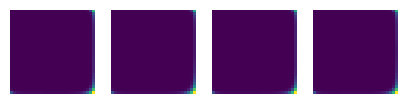

469/469 [==============================] - 65s 94ms/step - discriminator_loss: 0.3065 - generator_loss: 2.3505 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 2/100
469/469 [==============================] - 42s 88ms/step - discriminator_loss: 0.2676 - generator_loss: 2.6271 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 3/100
469/469 [==============================] - 42s 88ms/step - discriminator_loss: 0.2670 - generator_loss: 2.6558 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 4/100
469/469 [==============================] - 42s 89ms/step - discriminator_loss: 0.3493 - generator_loss: 2.4323 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 5/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.4166 - generator_loss: 1.2798 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 6/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.5733 - generator_loss: 0.8918

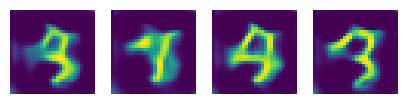

469/469 [==============================] - 43s 92ms/step - discriminator_loss: 0.5736 - generator_loss: 0.8914 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 7/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.5984 - generator_loss: 0.9305 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 8/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6161 - generator_loss: 0.8433 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 9/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6209 - generator_loss: 0.8507 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 10/100
469/469 [==============================] - 43s 92ms/step - discriminator_loss: 0.6116 - generator_loss: 0.8407 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 11/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6153 - generator_loss: 0.8486

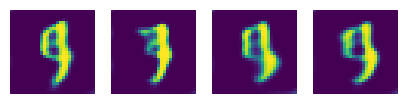

469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6152 - generator_loss: 0.8488 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 12/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6282 - generator_loss: 0.8470 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 13/100
469/469 [==============================] - 43s 90ms/step - discriminator_loss: 0.6262 - generator_loss: 0.7885 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 14/100
469/469 [==============================] - 43s 92ms/step - discriminator_loss: 0.6356 - generator_loss: 0.8101 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 15/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6340 - generator_loss: 0.7984 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 16/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6411 - generator_loss: 0.8063

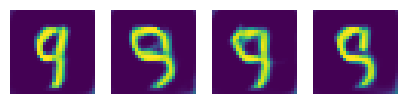

469/469 [==============================] - 43s 92ms/step - discriminator_loss: 0.6411 - generator_loss: 0.8064 - val_loss: 0.0000e+00 - lr: 0.0010
Epoch 17/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6490 - generator_loss: 0.7715 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 18/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6545 - generator_loss: 0.7686 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 19/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6570 - generator_loss: 0.7605 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 20/100
469/469 [==============================] - 43s 90ms/step - discriminator_loss: 0.6623 - generator_loss: 0.7519 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 21/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6640 - generator_loss: 0.7424

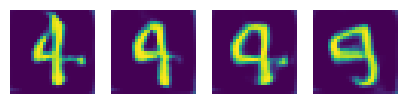

469/469 [==============================] - 43s 92ms/step - discriminator_loss: 0.6641 - generator_loss: 0.7425 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 22/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6694 - generator_loss: 0.7495 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 23/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6704 - generator_loss: 0.7554 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 24/100
469/469 [==============================] - 44s 93ms/step - discriminator_loss: 0.6723 - generator_loss: 0.7450 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 25/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6753 - generator_loss: 0.7394 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 26/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6786 - generator_loss: 0.7214

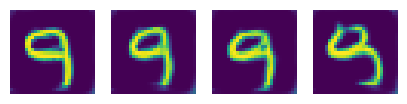

469/469 [==============================] - 44s 94ms/step - discriminator_loss: 0.6786 - generator_loss: 0.7212 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 27/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6796 - generator_loss: 0.7323 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 28/100
469/469 [==============================] - 43s 90ms/step - discriminator_loss: 0.6785 - generator_loss: 0.7287 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 29/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6804 - generator_loss: 0.7402 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 30/100
469/469 [==============================] - 43s 92ms/step - discriminator_loss: 0.6807 - generator_loss: 0.7207 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 31/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6831 - generator_loss: 0.7192

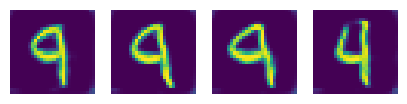

469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6831 - generator_loss: 0.7191 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 32/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6829 - generator_loss: 0.7330 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 33/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6837 - generator_loss: 0.7205 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 34/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6791 - generator_loss: 0.7513 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 35/100
469/469 [==============================] - 44s 93ms/step - discriminator_loss: 0.6837 - generator_loss: 0.7369 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 36/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6829 - generator_loss: 0.7322

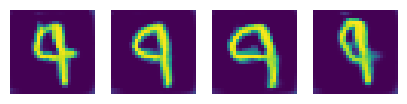

469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6829 - generator_loss: 0.7322 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 37/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6846 - generator_loss: 0.7266 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 38/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6850 - generator_loss: 0.7183 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 39/100
469/469 [==============================] - 43s 92ms/step - discriminator_loss: 0.6853 - generator_loss: 0.7215 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 40/100
469/469 [==============================] - 44s 93ms/step - discriminator_loss: 0.6854 - generator_loss: 0.7261 - val_loss: 0.0000e+00 - lr: 1.0000e-04
Epoch 41/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6840 - generator_loss: 0.7373

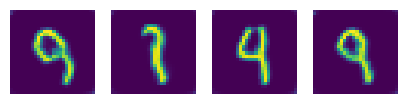

469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6840 - generator_loss: 0.7373 - val_loss: 0.0000e+00 - lr: 1.0000e-05
Epoch 42/100
469/469 [==============================] - 44s 93ms/step - discriminator_loss: 0.6864 - generator_loss: 0.7358 - val_loss: 0.0000e+00 - lr: 1.0000e-05
Epoch 43/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6864 - generator_loss: 0.7359 - val_loss: 0.0000e+00 - lr: 1.0000e-05
Epoch 44/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6861 - generator_loss: 0.7279 - val_loss: 0.0000e+00 - lr: 1.0000e-05
Epoch 45/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6873 - generator_loss: 0.7210 - val_loss: 0.0000e+00 - lr: 1.0000e-05
Epoch 46/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6859 - generator_loss: 0.7348

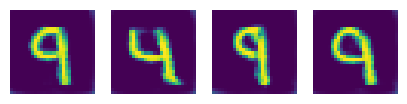

469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6859 - generator_loss: 0.7350 - val_loss: 0.0000e+00 - lr: 1.0000e-05
Epoch 47/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6878 - generator_loss: 0.7330 - val_loss: 0.0000e+00 - lr: 1.0000e-05
Epoch 48/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6859 - generator_loss: 0.7404 - val_loss: 0.0000e+00 - lr: 1.0000e-05
Epoch 49/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6872 - generator_loss: 0.7251 - val_loss: 0.0000e+00 - lr: 1.0000e-05
Epoch 50/100
469/469 [==============================] - 43s 92ms/step - discriminator_loss: 0.6872 - generator_loss: 0.7386 - val_loss: 0.0000e+00 - lr: 1.0000e-05
Epoch 51/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6880 - generator_loss: 0.7352

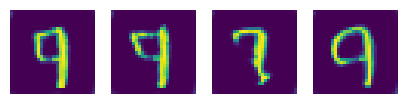

469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6881 - generator_loss: 0.7351 - val_loss: 0.0000e+00 - lr: 1.0000e-06
Epoch 52/100
469/469 [==============================] - 43s 92ms/step - discriminator_loss: 0.6871 - generator_loss: 0.7505 - val_loss: 0.0000e+00 - lr: 1.0000e-06
Epoch 53/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6875 - generator_loss: 0.7344 - val_loss: 0.0000e+00 - lr: 1.0000e-06
Epoch 54/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6890 - generator_loss: 0.7349 - val_loss: 0.0000e+00 - lr: 1.0000e-06
Epoch 55/100
469/469 [==============================] - 43s 92ms/step - discriminator_loss: 0.6891 - generator_loss: 0.7331 - val_loss: 0.0000e+00 - lr: 1.0000e-06
Epoch 56/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6893 - generator_loss: 0.7369

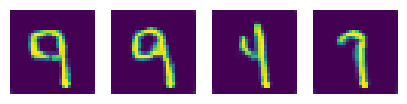

469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6893 - generator_loss: 0.7368 - val_loss: 0.0000e+00 - lr: 1.0000e-06
Epoch 57/100
469/469 [==============================] - 44s 93ms/step - discriminator_loss: 0.6884 - generator_loss: 0.7378 - val_loss: 0.0000e+00 - lr: 1.0000e-06
Epoch 58/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6898 - generator_loss: 0.7484 - val_loss: 0.0000e+00 - lr: 1.0000e-06
Epoch 59/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6892 - generator_loss: 0.7364 - val_loss: 0.0000e+00 - lr: 1.0000e-06
Epoch 60/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6885 - generator_loss: 0.7449 - val_loss: 0.0000e+00 - lr: 1.0000e-06
Epoch 61/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6889 - generator_loss: 0.7307

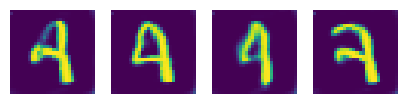

469/469 [==============================] - 43s 92ms/step - discriminator_loss: 0.6889 - generator_loss: 0.7308 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 62/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6885 - generator_loss: 0.7427 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 63/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6890 - generator_loss: 0.7372 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 64/100
469/469 [==============================] - 43s 90ms/step - discriminator_loss: 0.6890 - generator_loss: 0.7412 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 65/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6890 - generator_loss: 0.7411 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 66/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6886 - generator_loss: 0.7438

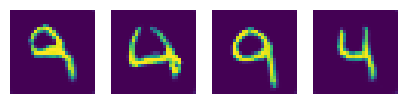

469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6885 - generator_loss: 0.7438 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 67/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6902 - generator_loss: 0.7275 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 68/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6901 - generator_loss: 0.7387 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 69/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6864 - generator_loss: 0.7618 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 70/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6880 - generator_loss: 0.7522 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 71/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6896 - generator_loss: 0.7364

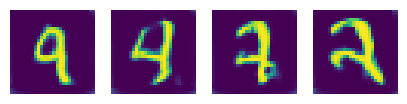

469/469 [==============================] - 43s 92ms/step - discriminator_loss: 0.6896 - generator_loss: 0.7366 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 72/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6896 - generator_loss: 0.7393 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 73/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6887 - generator_loss: 0.7519 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 74/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6888 - generator_loss: 0.7284 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 75/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6893 - generator_loss: 0.7400 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 76/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6893 - generator_loss: 0.7379

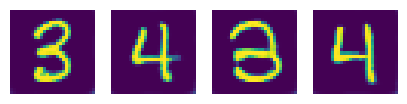

469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6893 - generator_loss: 0.7380 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 77/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6902 - generator_loss: 0.7284 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 78/100
469/469 [==============================] - 43s 92ms/step - discriminator_loss: 0.6894 - generator_loss: 0.7455 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 79/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6898 - generator_loss: 0.7336 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 80/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6880 - generator_loss: 0.7485 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 81/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6906 - generator_loss: 0.7332

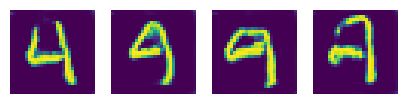

469/469 [==============================] - 43s 92ms/step - discriminator_loss: 0.6906 - generator_loss: 0.7333 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 82/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6903 - generator_loss: 0.7384 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 83/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6899 - generator_loss: 0.7328 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 84/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6893 - generator_loss: 0.7452 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 85/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6894 - generator_loss: 0.7399 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 86/100
469/469 [==============================] - ETA: 0s - discriminator_loss: 0.6878 - generator_loss: 0.7452

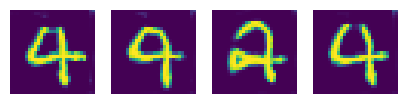

469/469 [==============================] - 43s 92ms/step - discriminator_loss: 0.6878 - generator_loss: 0.7453 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 87/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6758 - generator_loss: 0.7964 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 88/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6621 - generator_loss: 0.8541 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 89/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6330 - generator_loss: 1.0011 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 90/100
469/469 [==============================] - 43s 91ms/step - discriminator_loss: 0.6580 - generator_loss: 0.8938 - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 91/100
469/469 [==============================] - ETA: 0s - discriminator_loss: nan - generator_loss: nan

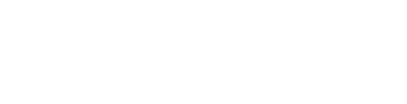

469/469 [==============================] - 38s 81ms/step - discriminator_loss: nan - generator_loss: nan - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 92/100
469/469 [==============================] - 37s 79ms/step - discriminator_loss: nan - generator_loss: nan - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 93/100
469/469 [==============================] - 37s 78ms/step - discriminator_loss: nan - generator_loss: nan - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 94/100
469/469 [==============================] - 38s 81ms/step - discriminator_loss: nan - generator_loss: nan - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 95/100
469/469 [==============================] - 38s 81ms/step - discriminator_loss: nan - generator_loss: nan - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 96/100
469/469 [==============================] - ETA: 0s - discriminator_loss: nan - generator_loss: nan

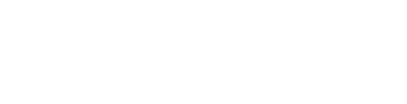

469/469 [==============================] - 37s 80ms/step - discriminator_loss: nan - generator_loss: nan - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 97/100
469/469 [==============================] - 38s 81ms/step - discriminator_loss: nan - generator_loss: nan - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 98/100
469/469 [==============================] - 38s 80ms/step - discriminator_loss: nan - generator_loss: nan - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 99/100
469/469 [==============================] - 37s 79ms/step - discriminator_loss: nan - generator_loss: nan - val_loss: 0.0000e+00 - lr: 1.0000e-07
Epoch 100/100
469/469 [==============================] - 38s 80ms/step - discriminator_loss: nan - generator_loss: nan - val_loss: 0.0000e+00 - lr: 1.0000e-07


In [89]:
# Fitting the model
history = fashion_gan.fit(train_data,
                          epochs = 100,
                          steps_per_epoch = len(train_data),
                          validation_data = test_data,
                          validation_steps = len(test_data),
                          callbacks = [custom_callback,
                                       model_checkpoint,
                                       early_stopping,
                                       reduce_lr])

### Results from our generator after training for 51 epochs.

In [91]:
# Loaded models
loaded_digit_gan = GAN(generator, discriminator)
loaded_digit_gan.load_weights('/content/generator_model_checkpoint/cp.ckpt')

1/1 [==============================] - 0s 70ms/step


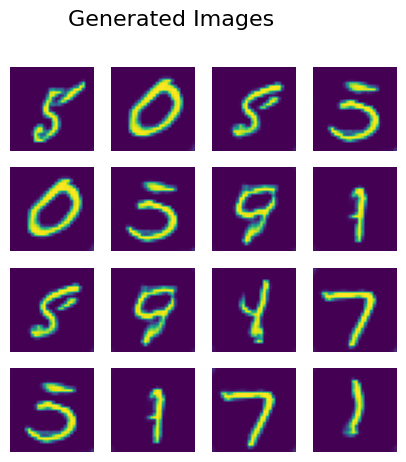

In [92]:
imgs = loaded_digit_gan.generator.predict(tf.random.normal((16, 128, 1)))
fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize = (5, 5))
plt.title("Generated Images", fontsize = 16, x = -1.7, y = 5)
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1)*(c+1)-1])
    ax[r][c].axis("off")

## Plotting Loss Curves

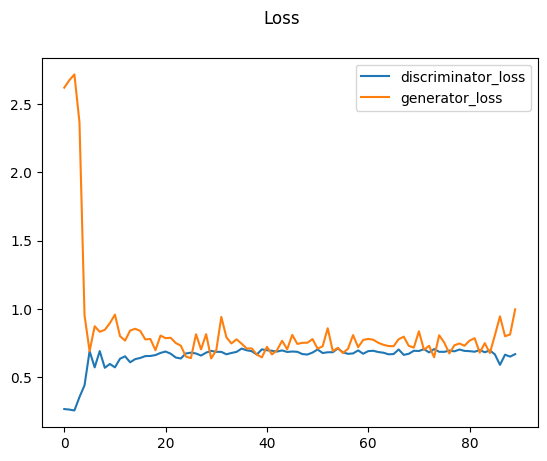

In [93]:
plt.suptitle('Loss')
plt.plot(history.history['discriminator_loss'], label='discriminator_loss')
plt.plot(history.history['generator_loss'], label='generator_loss')
plt.legend()
plt.show()

## Saving the model

In [95]:
# Save the model
loaded_digit_gan.generator.save('digit_gan_generator.h5')
loaded_digit_gan.discriminator.save('digit_gan_discriminator.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
